Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [158]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [60]:
#from google.colab import drive
#drive.mount('/content/drive')

In [159]:
#wiki = open('/content/drive/MyDrive/Colab Notebooks/wiki_data.txt').read().split('\n')
wiki = open('wiki_data.txt').read().split('\n')
len(wiki)

20003

In [160]:
from pymystem3 import Mystem
import re
mystem = Mystem()

def lem_preprocess(text):
    text = re.sub('#+', ' ', text.lower())
    # лемматизация в Mystem
    words_analyzed = mystem.analyze(text)
    lemmas = [parse['analysis'][0]['lex'] for parse in words_analyzed if parse.get('analysis')]
    lemmatized_tokens = [lemma.lower() for lemma in lemmas]
    lemmatized_tokens = [token.strip(punctuation) for token in lemmatized_tokens]
    lemmatized_tokens = [token for token in lemmatized_tokens if token]

    return lemmatized_tokens

In [161]:
vocab = Counter()

for text in wiki:
    vocab.update(lem_preprocess(text))

In [162]:
len(vocab)

143035

In [163]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 20:
        filtered_vocab.add(word)

In [164]:
len(filtered_vocab)

15318

In [165]:
# словарь с индексами
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [166]:
id2word = {i:word for word, i in word2id.items()}

In [167]:
# Заменяем слова на индексы.
sentences = []

for text in wiki:
    tokens = lem_preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [168]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

## Skip Gram, negative sampling

In [73]:
vocab_size = len(id2word)

In [74]:

# skip gram
def gen_batches_sg(sentences, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [75]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

skip_gram_embedding_model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
skip_gram_embedding_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
skip_gram_embedding_model.fit(gen_batches_sg(sentences, window=3),
          validation_data=gen_batches_sg(sentences,  window=3),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
10000/10000 [==============================] - 1355s 136ms/step - loss: 0.3727 - accuracy: 0.8403 - val_loss: 0.4016 - val_accuracy: 0.8182
Epoch 2/3
10000/10000 [==============================] - 1478s 148ms/step - loss: 0.3783 - accuracy: 0.8411 - val_loss: 0.3441 - val_accuracy: 0.8572
Epoch 3/3
10000/10000 [==============================] - 1336s 134ms/step - loss: 0.3777 - accuracy: 0.8418 - val_loss: 0.3021 - val_accuracy: 0.8716


In [84]:
skip_gram_embeddings = skip_gram_embedding_model.layers[2].get_weights()[0]

In [85]:
most_similar('школа', skip_gram_embeddings)

['школа',
 'училище',
 'интернат',
 'общеобразовательный',
 'гимназия',
 'обучаться',
 'учиться',
 'студент',
 'преподавать',
 'оканчивать']

In [86]:
most_similar('награда', skip_gram_embeddings)

['награда',
 'вручаться',
 'лауреат',
 'приз',
 'премия',
 'грэмми',
 'диплом',
 'эмми',
 'вручать',
 'удостоить']

In [87]:
most_similar('дуб', skip_gram_embeddings)

['дуб',
 'сосна',
 'береза',
 'хвойный',
 'липа',
 'ель',
 'произрастать',
 'луг',
 'клен',
 'массив']

## CBOW, negative sampling

In [169]:
# cbow
def gen_batches_cbow(sentences, window = 8, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [170]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

cbow_model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cbow_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [171]:
cbow_model.fit(gen_batches_cbow(sentences, window=8),
          validation_data=gen_batches_cbow(sentences,  window=8),
          batch_size=1000,
          steps_per_epoch=4000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
4000/4000 [==============================] - 408s 102ms/step - loss: 0.3593 - accuracy: 0.8476 - val_loss: 0.2915 - val_accuracy: 0.8810
Epoch 2/2
4000/4000 [==============================] - 432s 108ms/step - loss: 0.2880 - accuracy: 0.8846 - val_loss: 0.2964 - val_accuracy: 0.8832


In [172]:
cbow_embeddings = cbow_model.layers[2].get_weights()[0]

In [173]:
most_similar('школа', cbow_embeddings)

['школа',
 'студент',
 'работать',
 'университет',
 'учиться',
 'училище',
 'учитель',
 'институт',
 'искусство',
 'обучаться']

In [174]:
most_similar('награда', cbow_embeddings)

['награда',
 'медаль',
 'награждать',
 'удостаиваться',
 'вручаться',
 'премия',
 'вручать',
 'заслуга',
 'награждение',
 'приз']

In [175]:
most_similar('дуб', cbow_embeddings)

['дуб',
 'береза',
 'сосна',
 'широколиственный',
 'лягушка',
 'субальпийский',
 'произрастать',
 'липа',
 'хвойный',
 'листва']

In [176]:
cbow_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 1, 200)               3063800   ['input_20[0][0]']            
                                                                                                  
 embedding_20 (Embedding)    (None, 10, 200)              3063800   ['input_21[0][0]']            
                                                                                           

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

## *word2vec*

In [179]:
#!pip install gensim

In [20]:
import gensim

In [21]:
?gensim.models.Word2Vec

In [193]:
gensim.__version__

'4.3.2'

In [22]:
wiki = open('/content/drive/MyDrive/Colab Notebooks/wiki_data.txt').read().split('\n')

In [23]:
len(wiki)

20003

In [24]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [25]:
texts = [preprocess(text) for text in wiki]

In [26]:
len(texts)

20003

In [48]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=100,
                             min_count=2,
                             max_vocab_size=2000000,
                             window=7,
                             epochs=10,
                             sg=0,
                             hs=0,
                             negative=10,
                             ns_exponent=0.75)

CPU times: user 4min 38s, sys: 983 ms, total: 4min 39s
Wall time: 2min 47s


In [49]:
w2v.wv.most_similar('школа')

[('библиотека', 0.8635463118553162),
 ('больница', 0.8274450898170471),
 ('начальная', 0.8189181685447693),
 ('общеобразовательная', 0.794535756111145),
 ('школа»', 0.774200439453125),
 ('мельница', 0.7735310792922974),
 ('мечеть', 0.7665143013000488),
 ('земская', 0.7623246908187866),
 ('церковно-приходская', 0.7528213858604431),
 ('амбулатория', 0.7400420308113098)]

In [50]:
w2v.wv.most_similar('награда')

[('премия', 0.8354505896568298),
 ('ежегодная', 0.8080328702926636),
 ('вручаемая', 0.7899661660194397),
 ('присуждаемая', 0.7689447402954102),
 ('вручается', 0.7675710320472717),
 ('роль»', 0.7424097061157227),
 ('присуждается', 0.7419078350067139),
 ('награждена', 0.7342870831489563),
 ('удостоена', 0.7277912497520447),
 ('вручалась', 0.7214802503585815)]

In [51]:
w2v.wv.most_similar('дуб')

[('сосна', 0.888418436050415),
 ('лесной', 0.83096843957901),
 ('ель', 0.8297629952430725),
 ('черешчатый', 0.8231375813484192),
 ('лиственница', 0.8215847015380859),
 ('массив', 0.8167522549629211),
 ('певун', 0.8114539384841919),
 ('липа', 0.8084785342216492),
 ('бук', 0.8066466450691223),
 ('сосны', 0.8055039048194885)]

## *fastext*

In [167]:
%%time
ft = gensim.models.FastText(
    texts,
    min_n=4,
    max_n=9,
    vector_size=200,
    min_count=20,
    max_vocab_size=18000,
    window=7,
    epochs=6
)

CPU times: user 4min 14s, sys: 1.86 s, total: 4min 16s
Wall time: 2min 29s


In [168]:
ft.wv.most_similar('церковь')

[('церкви', 0.7999461889266968),
 ('храм', 0.7809791564941406),
 ('построена', 0.766800582408905),
 ('храма', 0.7586629986763),
 ('церквей', 0.7304018139839172),
 ('монастыря', 0.7257094979286194),
 ('монастырь', 0.725253701210022),
 ('монастыре', 0.7233832478523254),
 ('иконы', 0.6746119856834412),
 ('собор', 0.6553686857223511)]

In [169]:
ft.wv.most_similar('награда')

[('наград', 0.9833800196647644),
 ('награды', 0.9741664528846741),
 ('«за', 0.7661421298980713),
 ('награждён', 0.7626065015792847),
 ('медалью', 0.7455712556838989),
 ('медалями', 0.7408798933029175),
 ('заслуги', 0.736426591873169),
 ('«золотой', 0.7206846475601196),
 ('ордена', 0.7107876539230347),
 ('орденом', 0.7028277516365051)]

In [ ]:
ft.wv.most_similar('дуб')

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [178]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labeled.csv')
data = pd.read_csv('labeled.csv')

## 1) Эмбединги skip gram из первого задания

In [179]:
data['norm_text'] = data.comment.apply(lem_preprocess)

In [180]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд, то, за, что, дебил]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновлять, дебил, это, тоже, не, ос..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убеждать, страничный, в, то, что, скр..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибегать, и, ныть, ..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что, ли, и..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть, утомленный, солнце, и, оказыватьс..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, т, к, в..."


In [181]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6058

In [182]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [183]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [184]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

In [185]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [186]:
X_train.shape

(13691, 300)

In [187]:
y_train.shape

(13691,)

In [110]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = skip_gram_embedding_model.layers[2].get_weights()[0][i]

    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = np.random.rand(300)
        print(f"Word: {word}, Index: {i}, Random Weight: {weights}")

In [111]:


inputs = tf.keras.layers.Input(shape=(300,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)


Epoch 1/50
428/428 [==============================] - 5s 9ms/step - loss: 0.6572 - accuracy: 0.6651 - val_loss: 0.6498 - val_accuracy: 0.6463
Epoch 2/50
428/428 [==============================] - 4s 9ms/step - loss: 0.6320 - accuracy: 0.6661 - val_loss: 0.6466 - val_accuracy: 0.6463
Epoch 3/50
428/428 [==============================] - 4s 10ms/step - loss: 0.6286 - accuracy: 0.6661 - val_loss: 0.6472 - val_accuracy: 0.6463
Epoch 4/50
428/428 [==============================] - 4s 8ms/step - loss: 0.6280 - accuracy: 0.6661 - val_loss: 0.6477 - val_accuracy: 0.6463
Epoch 5/50
428/428 [==============================] - 4s 9ms/step - loss: 0.6277 - accuracy: 0.6661 - val_loss: 0.6474 - val_accuracy: 0.6463
Epoch 6/50
428/428 [==============================] - 4s 9ms/step - loss: 0.6274 - accuracy: 0.6661 - val_loss: 0.6474 - val_accuracy: 0.6463
Epoch 7/50
428/428 [==============================] - 4s 9ms/step - loss: 0.6271 - accuracy: 0.6661 - val_loss: 0.6473 - val_accuracy: 0.6463
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


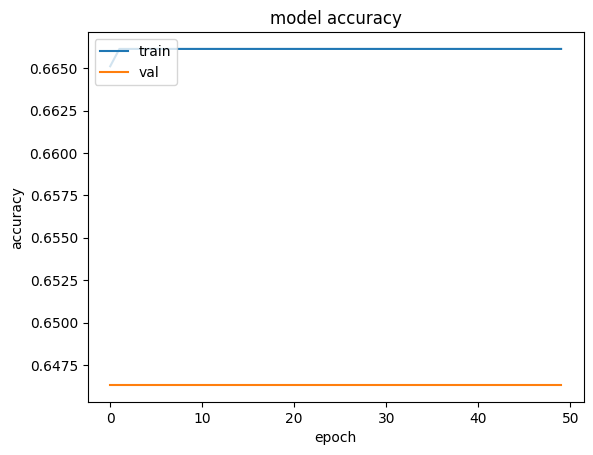

In [113]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# не получилось((

## 2) Эмбединги CBOW из первого задания

In [191]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=200)
y = data.toxic.values

In [192]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [208]:
model.layers

In [210]:
embedding_layer = cbow_model.get_layer('embedding_19')
embedding_weights = embedding_layer.get_weights()[0]

In [211]:
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = embedding_weights[word2id[word]]
       #weights[i] = cbow_model.get_layer('embedding_19').get_weights()[0][i]

    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = np.random.rand(200)

In [212]:
inputs = tf.keras.layers.Input(shape=(200,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [213]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 7ms/step - loss: 0.6458 - accuracy: 0.6625 - val_loss: 0.6344 - val_accuracy: 0.6574
Epoch 2/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6272 - accuracy: 0.6655 - val_loss: 0.6331 - val_accuracy: 0.6574
Epoch 3/30
428/428 [==============================] - 3s 7ms/step - loss: 0.6266 - accuracy: 0.6655 - val_loss: 0.6330 - val_accuracy: 0.6574
Epoch 4/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6263 - accuracy: 0.6655 - val_loss: 0.6328 - val_accuracy: 0.6574
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6261 - accuracy: 0.6655 - val_loss: 0.6329 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6260 - accuracy: 0.6655 - val_loss: 0.6326 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6258 - accuracy: 0.6655 - val_loss: 0.6326 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


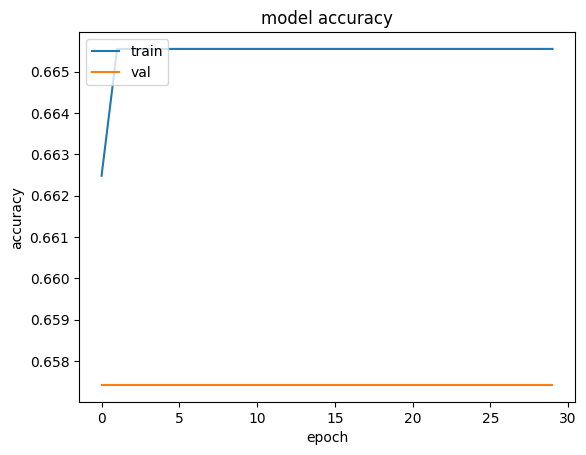

In [214]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# не работает :((

## 3) Эмбединги word2vec из второго задания

In [54]:
# предобработка без лемматизации
data['norm_text'] = data.comment.apply(preprocess)

In [55]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюдов-то, за, что, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страницу, обнови, дебил, это, тоже, не, оскор..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[тебя, не, убедил, 6-страничный, пдф, в, том, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежал, и, ноет, а..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кого, любить, гоблина, тупорылого, что-ли,..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотрел, утомленных, солнцем, 2, и, оказало..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушает, правила, раздела, т.к, в..."


In [56]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7231

In [57]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [58]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [59]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [61]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [62]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [63]:
# Обучаем модель
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 2ms/step - loss: 0.6117 - accuracy: 0.6629 - val_loss: 0.5793 - val_accuracy: 0.6921
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5889 - accuracy: 0.6672 - val_loss: 0.5647 - val_accuracy: 0.6963
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5763 - accuracy: 0.6739 - val_loss: 0.5525 - val_accuracy: 0.7004
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5675 - accuracy: 0.6807 - val_loss: 0.5474 - val_accuracy: 0.7129
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5610 - accuracy: 0.6890 - val_loss: 0.5388 - val_accuracy: 0.7212
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5561 - accuracy: 0.6935 - val_loss: 0.5349 - val_accuracy: 0.7212
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5521 - accuracy: 0.6981 - val_loss: 0.5305 - val_accuracy: 0.7268
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


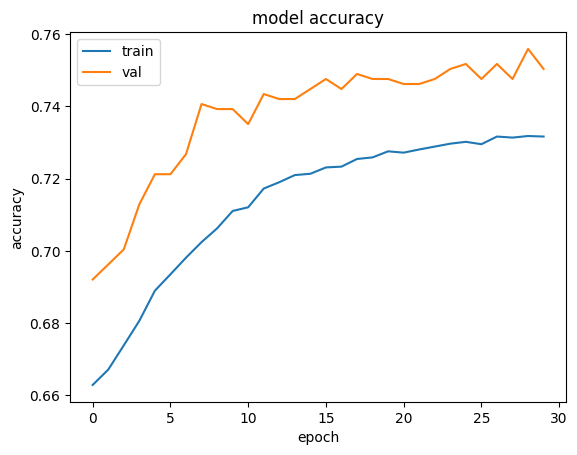

In [64]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 4) Эмбединги fastext из второго задания

In [173]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=200)
y = data.toxic.values

In [174]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [175]:
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']


In [176]:
inputs = tf.keras.layers.Input(shape=(200,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [177]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6319 - accuracy: 0.6628 - val_loss: 0.5954 - val_accuracy: 0.6838
Epoch 2/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6170 - accuracy: 0.6642 - val_loss: 0.5860 - val_accuracy: 0.6838
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6097 - accuracy: 0.6644 - val_loss: 0.5788 - val_accuracy: 0.6852
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6045 - accuracy: 0.6647 - val_loss: 0.5760 - val_accuracy: 0.6879
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6008 - accuracy: 0.6670 - val_loss: 0.5693 - val_accuracy: 0.6879
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5977 - accuracy: 0.6691 - val_loss: 0.5672 - val_accuracy: 0.6893
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5953 - accuracy: 0.6699 - val_loss: 0.5657 - val_accuracy: 0.6907
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


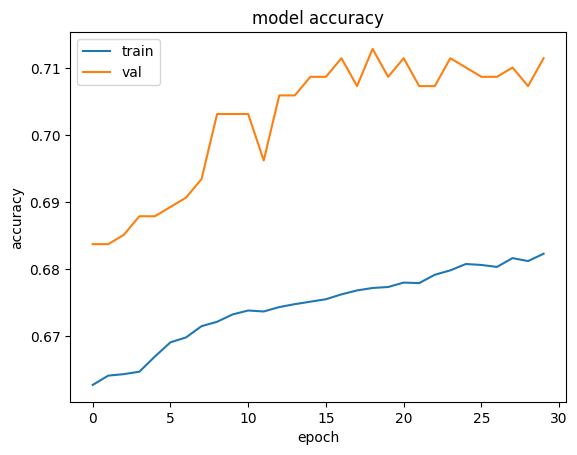

In [178]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 5) Эмбединги предобученной модели с rus-vectores

In [3]:
import gensim

In [4]:
rusvec_model = gensim.models.KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec', binary=False)

In [5]:
rusvec_model['март_NOUN']

array([ 0.077049,  0.047464,  0.06009 , -0.074989,  0.044796, -0.001967,
       -0.029693,  0.043408,  0.064917, -0.040833, -0.061425, -0.029607,
       -0.029905,  0.064318, -0.165209, -0.048543,  0.094033,  0.098251,
        0.120046,  0.023853,  0.016249, -0.015089, -0.05077 , -0.01809 ,
       -0.064637, -0.039266, -0.022106, -0.019366,  0.016014, -0.051354,
        0.046586, -0.024155,  0.062748,  0.000681,  0.05134 ,  0.049167,
        0.005723, -0.072041, -0.049427, -0.094474, -0.075772,  0.087238,
       -0.023207, -0.043947, -0.005014,  0.048574, -0.008169, -0.016334,
       -0.006644,  0.026402,  0.046584, -0.040629,  0.008602,  0.047264,
        0.00828 ,  0.089396, -0.030152, -0.011632,  0.016811,  0.081198,
       -0.042167, -0.004215,  0.079515,  0.061092,  0.065421, -0.090715,
       -0.07259 ,  0.061831,  0.036428,  0.024443,  0.040917,  0.043281,
        0.050277,  0.02531 ,  0.040681, -0.073628,  0.032021, -0.020285,
       -0.001634, -0.073642, -0.092016, -0.010889, 

In [6]:
rusvec_model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9506458044052124),
 ('ноябрь_NOUN', 0.9416142702102661),
 ('декабрь_NOUN', 0.9391436576843262),
 ('январь_NOUN', 0.9299512505531311),
 ('апрель_NOUN', 0.9271649718284607),
 ('октябрь_NOUN', 0.9204078316688538),
 ('сентябрь_NOUN', 0.9028568267822266),
 ('май_NOUN', 0.8944932222366333),
 ('июнь_NOUN', 0.8860151767730713),
 ('марта_NOUN', 0.8700184226036072)]

In [7]:
from pymystem3 import Mystem
m = Mystem()

In [8]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


In [9]:
mapping = {}
# https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map
for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [10]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [11]:
data['norm_text'] = data.comment.apply(normalize_mystem)

In [12]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд_NOUN, то_PART, за_ADP, что_PRON, деби..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол_NOUN, это_PART, отдушина_NOUN, затюканы..."
2,Собаке - собачья смерть\n,1.0,"[собака_NOUN, собачий_ADJ, смерть_NOUN]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница_NOUN, обновлять_VERB, дебил_NOUN, эт..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты_PRON, не_PART, убеждать_VERB, страничный_A..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий_ADJ, совковый_ADJ, скот_NOUN, прибега..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а_SCONJ, кто_PRON, любить_VERB, гоблин_NOUN, ..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть_VERB, утомленный_ADJ, солнце_NOUN,..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред_ADV, нарушать_VERB, правило_NOUN, р..."


In [50]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6216

In [51]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [52]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [53]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [55]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = rusvec_model[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = rusvec_model['опрагпллирао']

In [56]:
 #trainable=False

inputs = tf.keras.layers.Input(shape=(300,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [30]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=80)

Epoch 1/80
428/428 [==============================] - 4s 8ms/step - loss: 0.6657 - accuracy: 0.6623 - val_loss: 0.6375 - val_accuracy: 0.6921
Epoch 2/80
428/428 [==============================] - 3s 7ms/step - loss: 0.6378 - accuracy: 0.6637 - val_loss: 0.6184 - val_accuracy: 0.6921
Epoch 3/80
428/428 [==============================] - 3s 7ms/step - loss: 0.6295 - accuracy: 0.6637 - val_loss: 0.6117 - val_accuracy: 0.6921
Epoch 4/80
428/428 [==============================] - 3s 8ms/step - loss: 0.6261 - accuracy: 0.6637 - val_loss: 0.6084 - val_accuracy: 0.6921
Epoch 5/80
428/428 [==============================] - 3s 7ms/step - loss: 0.6234 - accuracy: 0.6637 - val_loss: 0.6056 - val_accuracy: 0.6921
Epoch 6/80
428/428 [==============================] - 3s 7ms/step - loss: 0.6209 - accuracy: 0.6637 - val_loss: 0.6032 - val_accuracy: 0.6921
Epoch 7/80
428/428 [==============================] - 3s 7ms/step - loss: 0.6184 - accuracy: 0.6637 - val_loss: 0.6010 - val_accuracy: 0.6921
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


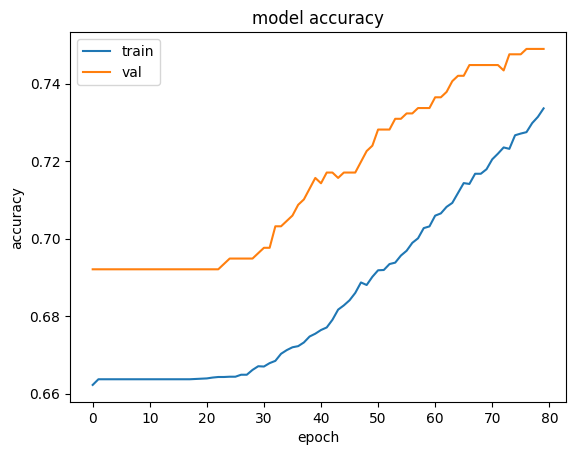

In [31]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
 #trainable=True

inputs = tf.keras.layers.Input(shape=(300,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [48]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=80)

Epoch 1/80
156/428 [=========>....................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9712

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


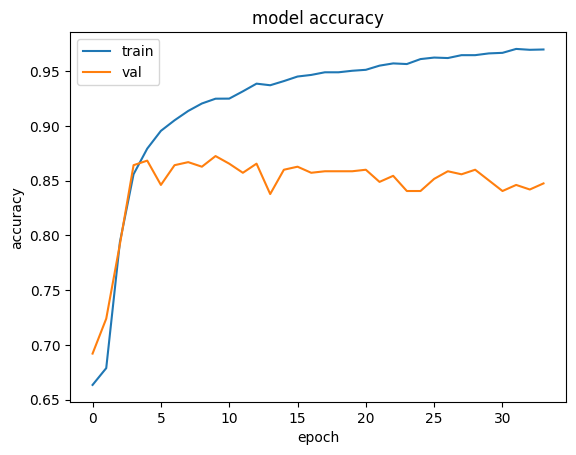

In [34]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# третья модель с эмбедингами word2vec из второго задания лучше всего получилась